In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from HelperFunctions import *
from PtOccupancyFunctions import *
import scipy.integrate
import pprint
from FindDataFunctions import *
from pprint import pprint
from IPython.core.display import display, HTML
from matplotlib import cm
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit

In [2]:
path = "/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/bimodal/output/3Alpha900Beta3000DistDifferentReqs/"

In [3]:
keys = ["reqs","dist","drt","dcut","l"]
values = [None,"3000","1000",None,None]

def readData():
    saved_path = os.path.join(path, "saved.pkl")
    
    # Load bimodal dataframe
    if os.path.isfile(saved_path):
        df = pd.read_pickle(saved_path)
    else:
        dcut_dirs = getDirs(path, keys, values)
        cols = ["requests","dcut", "l", "occupancy", "detour", "servability", "req_mean_dist", "drt_travel_time_normalized",
                "drt_wait_time_normalized", "drt_wait_time", "drt_distance", "cummulative_dist_drt",
                "cummulative_dist_drt_unshared", "pkm_drt", "idle_frac", "drt_ride_time"]
        df = pd.DataFrame(np.full((len(dcut_dirs),len(cols)), np.nan), columns=cols)
        for i,e in enumerate(dcut_dirs):
            row = df.iloc[i,:]
            try:
                row.loc["requests"] = float(e[0])
                row.loc["dcut"] = float(e[3])
                row.loc["l"] = float(e[4])
                dic = e[-1]
                row.loc["occupancy"], row.loc["idle_frac"] = getDrtOccupandyAndStandingFrac(dic, False, False)
                df_detour = getDrtDetours(dic)
                row.loc["detour"] = df_detour["distanceDetour"].mean()
                trip_succ = getTripSuccess(dic)
                row.loc["servability"] = len(trip_succ[trip_succ["tripSuccess"]]) / len(trip_succ)
                df_persons = getPersons(dic)
                row.loc["req_mean_dist"] = df_persons["mean_dist"].mean()
                drt_trips, drt_trips_perperson = getDrtTrips(dic)
                row.loc["cummulative_dist_drt"] = getDrtVehicleDistances(dic).sum()
                row.loc["cummulative_dist_drt_unshared"] = drt_trips["direcTravelDistance_m"].sum()
                df_detour = df_detour.set_index("person")
                row.loc["drt_wait_time"] = drt_trips_perperson["waitTime"].mean()
                row.loc["drt_wait_time_normalized"] = (drt_trips_perperson["waitTime"]/df_detour["unsharedTime"]).mean()
                row.loc["drt_travel_time_normalized"] = (drt_trips_perperson["travelTime"]/df_detour["unsharedTime"]).mean()
                row.loc["drt_distance"] = drt_trips_perperson["travelDistance_m"].mean()
                _, row.loc["pkm_drt"] = getModeStats(dic, [], ["drt"])
                row.loc["drt_ride_time"] = drt_trips_perperson["travelTime"].mean()
            except KeyError:
                print("KeyError")
                pass

            print("-----")

        df.to_pickle(saved_path)

    
    df = df.sort_values(["dcut", "l"])
#     display(df["l"])
#     display(df["dcut"])
    df["l"] /= df["req_mean_dist"].mean()
    df["dcut"] /= df["req_mean_dist"].mean()
    df["drt_wait_time"] /= df["req_mean_dist"].mean()/(30/3.6)
    df["drt_ride_time"] /= df["req_mean_dist"].mean()/(30/3.6)
#     data = np.einsum("ijk->jik", data)
    
    return df

---
# Visualization

In [4]:
# reqs = [10000, 15000, 20000, 25000, 30000]
# dfs = []
# for req in reqs:
#     df, df_car = readData(req)
#     df["efficiency"] = df["occupancy"]/df["detour"]
#     dfs.append(df)
df = readData()

print(len(df))
# print(str(df["req_mean_dist"].mean()) + " should be a lot larger than " + str(df["req_mean_dist"].std()))
# req_mean_dist = df["req_mean_dist"].mean()

3125


In [5]:
mean_dist = 3000
beta = 1/6*(np.sqrt(2)+np.log(1+np.sqrt(2)))

def inverseGammaDistUnnormalized(x, d_mean=mean_dist, k=3.1):
    if (x==0):
        return 0
    elif (x>5000):
        return 0
    else:
        z = x/d_mean
        return (z**(-k))*np.exp(-(k-2)/z)

normalization_inverse_gamma = scipy.integrate.quad(inverseGammaDistUnnormalized,0,np.infty)[0]

print("Normalization factor for InverseGamma distribution: ", normalization_inverse_gamma)

def inverseGammaDist_(x):
    return inverseGammaDistUnnormalized(x)/normalization_inverse_gamma

rpr_ = lambda x: x*inverseGammaDist_(x)

def getBimFrac_(dcut):
    return scipy.integrate.quad(inverseGammaDist, dcut, np.infty)[0]

def getBimFracAvDist_(ell, dcut):
    return getBimFrac_(dcut)*2*beta*ell

def getUniFrac_(dcut):
    return 1 - getBim_Frac_(dcut)

def getUniFracAvDist_(dcut):
    return scipy.integrate.quad(rpr_, 0, dcut)[0]

rpr = np.vectorize(rpr_)
inverseGammaDist = np.vectorize(inverseGammaDist_)
getBimFrac = np.vectorize(getBimFrac_)
getUniFrac = np.vectorize(getUniFrac_)
getBimFracAvDist = np.vectorize(getBimFracAvDist_)
getUniFracAvDist = np.vectorize(getUniFracAvDist_)
average_dist_theory = scipy.integrate.quad(rpr_,0,np.infty)[0]

Normalization factor for InverseGamma distribution:  2253.726079706043


In [6]:
Zs = []
dists = []
reqs = []
pbusys = []

for i,req in enumerate(df["requests"].unique()):
    subdf = df[df["requests"] == req]
    data = subdf.pivot(index="l", columns="dcut", values=["cummulative_dist_drt_unshared",
                                                          "cummulative_dist_drt",
                                                          "idle_frac"])
    Z = data["cummulative_dist_drt_unshared"]/data["cummulative_dist_drt"]
    if i == 0:
        ELL, DCUT = np.meshgrid(Z.index.to_numpy()*subdf["req_mean_dist"].mean(), Z.columns.to_numpy()*subdf["req_mean_dist"].mean(), indexing='ij')
        avDist = (getBimFracAvDist(ELL,DCUT) + getUniFracAvDist(DCUT))/average_dist_theory
#     plt.scatter(avDist, Z.to_numpy())
    reqs.append(req)
    Zs.append(Z)
    dists.append(avDist)
    pbusys.append(1-data["idle_frac"])

# plt.show()

In [7]:
def linFunc(x,a):
    return a*x

0.0010494198694343006
[5.1733433e-13]
r^2:  0.99203390660234


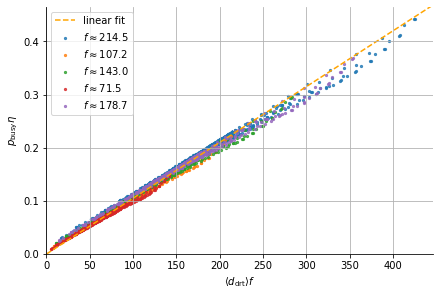

In [15]:
fig, ax = plt.subplots(constrained_layout=True)

sim_timescale = 9*3600 # T_sim [s]
timescale = average_dist_theory/(30/3.6) #<r>/v_drt
x = []
y = []

for Z,avDist,req,pbusy in zip(Zs, dists, reqs, pbusys):
    f = req/sim_timescale*timescale
    plt.scatter(avDist*f, Z.to_numpy()*pbusy, s=5, label=rf"$f \approx {round(f,1)}$", alpha=0.8, zorder=0)
    x.append(avDist*f)
    y.append(Z.to_numpy()*pbusy)

# popt, pcov = curve_fit(linFunc,x[0].flatten(),y[0].to_numpy().flatten())
x = np.concatenate(x).flatten()
y = np.concatenate(y).flatten()

popt, pcov = curve_fit(linFunc,x,y)
print(*popt)
print(*pcov)

cont_x = np.array([0,x.max()*1.1])
plt.plot(cont_x, linFunc(cont_x,*popt), c="orange", ls="--", zorder=1, label="linear fit")
# plt.plot(cont_x, linFunc(cont_x,popt[0]+np.sqrt(np.diag(pcov))[0]), c="red", alpha=0.5, ls="--", zorder=1, label="linear fit")

ax.set_ylim(0,y.max()*1.05)
ax.set_xlim(0,x.max()*1.05)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid()
ax.set_ylabel(r"$p_\mathrm{busy}\eta$")
ax.set_xlabel(r"$\langle d_\mathrm{drt}\rangle f$")
ax.legend()

residuals = y - linFunc(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print("r^2: ", r_squared)

# fig.savefig("Figures/EfficiencySupplyDemandCollapsed.pgf")
# fig.savefig("Figures/EfficiencySupplyDemand.pgf")
plt.show()

$$p_\text{busy}\eta = \frac{1}{N v_\text{drt}}\cdot f \langle d_{drt} \rangle$$

In [9]:
print(popt)
print(pcov)
print(np.sqrt(np.diag(pcov)))

[0.00104942]
[[5.1733433e-13]]
[7.19259571e-07]


In [10]:
1/popt[0]

952.907438791929